# **Statistical Experiments and Significance Testing**

In [43]:
# IPython magic to display plots inline in Jupyter notebooks
%matplotlib inline

# Standard Library
import random  # Provides functions for generating random numbers and selections
from pathlib import Path  # Object-oriented file system paths (cross-platform)

# Third-Party Libraries
import matplotlib.pyplot as plt  # Low-level plotting interface from Matplotlib
import numpy as np  # Core numerical computing library for arrays, math, etc.
import pandas as pd  # Data analysis and manipulation with labeled DataFrames
import seaborn as sns  # High-level statistical data visualization built on Matplotlib
from scipy import stats  # Statistical functions (e.g., distributions, tests, p-values)
from sklearn.utils import resample  # Resampling function used for bootstrapping
import statsmodels.api as sm  # Core API for statistical modeling and regression
import statsmodels.formula.api as smf  # Formula-based interface to statsmodels
from statsmodels.stats import power  # Tools for power analysis and sample size planning


In [44]:
data_dir = Path("Data3")
WEB_PAGE_DATA_CSV = data_dir / 'web_page_data.csv'


### **Example: Web Stickiness**

In [45]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times['Time'] = session_times['Time']*100
session_times.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


In [46]:
session_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Page    36 non-null     object 
 1   Time    36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 708.0+ bytes


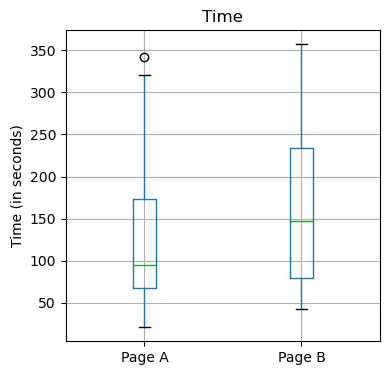

In [47]:
ax = session_times.boxplot(by='Page', column='Time',figsize=(4, 4)) #"Group the data by Page, and for each group, draw a boxplot of Time."
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

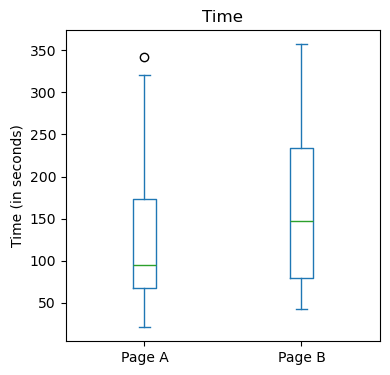

In [48]:
#We can use plot.box() in Pandas as an alternative to .boxplot(). In fact, both plot.box() and boxplot() are functionally equivalent in Pandas for creating boxplots.
ax = session_times.plot.box(by='Page', column='Time', figsize=(4, 4))
'''
session_times.plot.box(by='Page', column='Time', figsize=(4, 4)) returns a Pandas Series of Axes objects, not a single Axes object. Each element in this Series corresponds to a boxplot for each group defined by the by='Page' parameter.
Explanation
    -When you use by='Page' in plot.box(), Pandas creates a separate subplot for each unique value in the 'Page' column.
    -Therefore, the returned object ax is a Series where each element is a Matplotlib Axes object.
    -You cannot call set_xlabel() or set_ylabel() directly on this Series; you need to call these methods on individual Axes objects within the Series.
'''
for axis in ax:
    axis.set_xlabel('')
    axis.set_ylabel('Time (in seconds)')

plt.suptitle('')   # Remove the default suptitle added by 'by'
plt.tight_layout()
plt.show()




In [49]:
a = session_times.groupby('Page')['Time'].apply(list)
# a.shape (2,)
type(a) #pandas.core.series.Series
a
'''
Assuming session_times is a Pandas DataFrame with at least two columns:
    'Page': representing different pages (e.g., webpage names, page IDs)
    'Time': representing some time-related values (e.g., session durations, timestamps)

Step-by-step breakdown
session_times.groupby('Page')
This groups the DataFrame by the values in the 'Page' column.
All rows with the same 'Page' value are grouped together.
This creates a GroupBy object where you can perform operations on each group separately.

['Time']
After grouping, this selects the 'Time' column from each group.
So now, for each group (each unique page), you have the corresponding 'Time' values.

.apply(list)
This applies the list function to the 'Time' values in each group.
It converts the 'Time' values for each group into a Python list.
So instead of a Series or array of values, you get a list of times per page.

Result
The output is a Pandas Series where:
    The index is the unique values from the 'Page' column.
    The values are lists of 'Time' values corresponding to each page.
'''
# (a.values).shape    #(2,)
a.values
a.index

Index(['Page A', 'Page B'], dtype='object', name='Page')

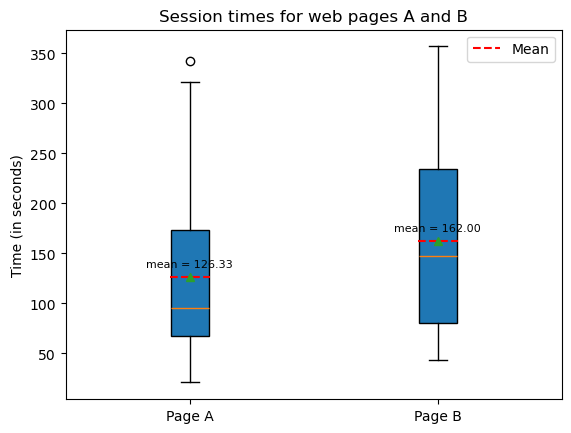

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your data into a Pandas DataFrame
data = session_times


# Group the data by 'Page'
grouped_data = data.groupby('Page')['Time'].apply(list)

# Create boxplot
fig, ax = plt.subplots()    #creating Matplotlib plot using object oriented method (This line uses Matplotlib's object-oriented interface to create a figure (fig) and a single set of axes (ax).)
ax.boxplot(grouped_data.values, vert=True, patch_artist=True, showmeans=True, tick_labels=grouped_data.index)

# Calculate means
means = [np.mean(group) for group in grouped_data.values]

# Add dashed lines for means
# list(enumerate(means))  #[(0, 1.2633333333333332), (1, 1.62)]
for i, mean in enumerate(means):
    ax.hlines(mean, i + 0.92, i + 1.08, colors='red', linestyles='dashed', label='Mean' if i == 0 else "")
    ax.text(i + 1, mean + 10, f"mean = {mean:.2f}", ha="center", fontsize=8)
'''
It iterates over a list called means, where i is the index and mean is the value at that index.

For each mean, it draws a horizontal dashed red line at the y-position equal to mean using ax.hlines(). The line extends horizontally from x = i + 0.92 to x = i + 1.09. This creates a short horizontal line centered roughly at x = i + 1 on the x-axis.

The label='Mean' if i == 0 else "" parameter ensures that only the first horizontal line gets the label "Mean" for the legend, avoiding repeated labels for subsequent lines.

Then, ax.text() adds a text annotation slightly above the horizontal line (at mean + 0.1 on the y-axis), centered at x = i + 1. The text displays the mean value formatted to two decimal places, e.g., "mean = 3.45".
'''
# Optional: Add a legend
ax.legend()

ax.set_title("Session times for web pages A and B")
ax.set_ylabel('Time (in seconds)')
plt.show()


In [51]:
session_times.groupby('Page')['Time'].mean()

Page
Page A    126.333333
Page B    162.000000
Name: Time, dtype: float64

In [52]:
mean_a = session_times[session_times.Page == 'Page A']['Time'].mean()
mean_b = session_times[session_times.Page == 'Page B']['Time'].mean()
print(mean_a)
print(mean_b)
print(mean_b - mean_a)

126.33333333333333
162.0
35.66666666666667



Now, the question is whether this difference (**$35.66$**) falls within the range of what random chance might produce (according to the null hypothesis), i.e., whether it is *statistically significant*.  
One way to answer this is by applying a permutation test: combine all the session times, then repeatedly shuffle and divide them into groups of $21$ (recall that $n_A = 21$ for page A) and $15$ ($n_B = 15$ for page B).  
To perform the permutation test, we need a function that randomly assigns the 36 session times to a group of 21 (page A) and a group of 15 (page B).


**Permutation Test Implementation Steps**  
1. **Data Pooling**:  
   Combine all session times from both groups (Page A and Page B).

2. **Resampling Process**:  
   Repeatedly:
   - Shuffle the pooled data
   - Split into two groups:
     - Group A: 21 samples (`nA = 21`)
     - Group B: 15 samples (`nB = 15`)

3. **Function Requirement**:  
   Create a helper function `perm_fun` that:
   - Takes pooled data array
   - Randomly assigns 21 values to Group A
   - Assigns remaining 15 to Group B
   - Returns both groups

In [53]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()
    
nA = session_times[session_times['Page'] == 'Page A'].shape[0]
nB = session_times[session_times['Page'] == 'Page B'].shape[0]
'''
perm_fun(x, nA, nB): This function takes three arguments: x (a pandas Series containing the session times), nA (the number of observations for Page A), and nB (the number of observations for Page B).
n = nA + nB: Calculates the total number of observations.
idx_B = set(random.sample(range(n), nB)): This line randomly selects nB indices from the range 0 to n-1 without replacement. These indices represent the randomly assigned observations for group B. The set() function is used to ensure that the indices are unique.
idx_A = set(range(n)) - idx_B: This line determines the indices for group A by taking the set difference between all possible indices (0 to n-1) and the indices already assigned to group B.
return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean(): This line calculates the difference in means between the two randomly assigned groups. It uses .loc to select the session times corresponding to the indices in idx_B and idx_A, calculates the mean for each group, and returns the difference.
'''
print(perm_fun(session_times['Time'], nA, nB))

-18.161904761904765


function `perm_fun` works by sampling (without replacement) $nB$ indices and assigning them to the B group; the remaining $nA$ indices are assigned to group A. The difference between the two means is returned. Calling this function R=1,000 times and specifying $nA = 21$ and $nB = 15$ leads to a distribution of the differences between the means of the two groups in the session times, that can be plotted as a histogram.


Text(0, 0.5, 'Frequency')

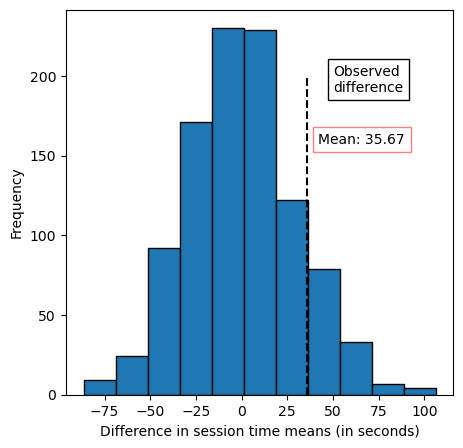

In [54]:
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, edgecolor = 'black')
'''
Plots a histogram of the permutation differences in session time means (perm_diffs) with 11 bins, showing the frequency of each range of differences.
This histogram visually represents the null distribution of differences under random assignment.
'''
difff =  mean_b - mean_a
# ax.axvline(x = mean_b - mean_a, color='black', lw=2)  #Draws a vertical black line at the observed difference in means between the actual groups.

ax.plot([ difff, difff], [0, 200], color='black', linestyle='--')
ax.text(difff +30, 160, f'Mean: {difff:.2f}',
        bbox=dict(facecolor='white', edgecolor='red', alpha=0.5),
        ha='center', va='center')


ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Difference in session time means (in seconds)')
ax.set_ylabel('Frequency')

The histogram, in the figure above shows that mean difference of random permutations often exceeds the observed difference in session times (the vertical line). For our results, this happens in 12.6% of the cases:

In [ ]:
# convert perm_diffs to numpy array to avoid problems with some Python installations
perm_diffs = np.array(perm_diffs)
p_value = np.mean(perm_diffs >= mean_b - mean_a) #perm_diffs > mean_b - mean_a returns an array of True/False values.
print(f'p_value: {p_value:.3f}')
'''
perm_diffs = np.array(perm_diffs): This converts the list perm_diffs (which contains the 1000 permutation differences) into a NumPy array. Using a NumPy array ensures compatibility and efficient numerical operations, avoiding potential issues with some Python environments or libraries that expect NumPy arrays for vectorized computations.
np.mean(perm_diffs > mean_b - mean_a): This expression calculates the proportion of permutation differences that are greater than the observed difference (mean_b - mean_a).
perm_diffs > mean_b - mean_a creates a boolean array where each element is True if the permutation difference exceeds the observed difference, and False otherwise.
Taking the mean of this boolean array treats True as 1 and False as 0, so the result is the fraction of permutations where the difference was larger than observed.
Purpose: This fraction represents the p-value in the permutation test. It quantifies the probability of observing a difference as extreme as (or more extreme than) the actual difference under the null hypothesis of no difference. A small p-value suggests that the observed difference is statistically significant and unlikely due to random chance.
In summary, this code computes the p-value of the permutation test by comparing the observed difference to the distribution of mean differences generated by random shuffling, helping to assess statistical significance.
''';

p_value: 0.123


**Why is `np.mean(perm_diffs >= mean_b - mean_a)` equal to the p-value?**

The expression `np.mean(perm_diffs >= mean_b - mean_a)` is equal to the p-value in a permutation test because it directly estimates the probability, under the null hypothesis, of observing a test statistic as extreme or more extreme than the actual observed difference (the actual observed test statistic).

**Here is why:**  

- **Permutation test null hypothesis:**  
  The two groups come from the same distribution, so any observed difference in means is due to random chance.

- **Generating the null distribution:**  
  By repeatedly shuffling the combined data and recalculating the difference in means, you simulate many possible outcomes if the null hypothesis were true. These simulated differences form the *null distribution* (also called *permutation distribution*) of the test statistic.

- **Observed difference:**  
  The actual difference in means between the original groups is compared against this null distribution.

- **Calculating the p-value:**  
  The p-value is the probability of seeing a difference at least as extreme as the observed one, assuming the null hypothesis is true. In practice, this is estimated by the proportion of permuted differences that are greater than (or as extreme as) the observed difference.

Mathematically, if $T_{obs}$ is the observed test statistic and $T_i$ are the permuted test statistics, then the p-value is estimated as:

$$
p \approx \frac{1}{N} \sum_{i=1}^N I(T_i \geq T_{obs})
$$

where $I$ is the indicator function (1 if true, 0 otherwise), and $N$ is the number of permutations.

**In our code:**  

```python
np.mean(perm_diffs > mean_b - mean_a)
```
where: 

- `perm_diffs` is the array of permuted differences $T_i$.
- `mean_b - mean_a` is the observed difference $T_{obs}$.

The expression counts how many permuted differences exceed the observed difference and divides by the total number of permutations, giving the estimated p-value.


**In summary**, this proportion represents the likelihood that the observed difference could arise by chance under the null hypothesis, which is exactly what the p-value quantifies in hypothesis testing.

---

Our observation about the p-value often being expressed as $1 - \text{CDF}$ (cumulative distribution function) is correct and aligns with classical hypothesis testing for continuous distributions. However, in the context of permutation tests, the formula

$$
p \approx \frac{1}{N} \sum_{i=1}^N I(T_i \geq T_{\text{obs}})
$$

is essentially an empirical estimate of that same tail probability, derived from the discrete null distribution generated by permutations.

Here's why they are consistent:

- The cumulative distribution function (CDF) at a point $x$ gives the probability $P(T \leq x)$.

- The p-value for a right-tailed test is 
  $$
  P(T \geq T_{\text{obs}}) = 1 - \text{CDF}(T_{\text{obs}}^-)
  $$
  $ \text{CDF}(T_{\text{obs}}^-) $ means the value of the CDF just before $ T_{\text{obs}} $, that is, approaching $ T_{\text{obs}} $ from the left side.  
  
  When the distribution is continuous, the CDF is continuous and

  $$
  \text{CDF}(T_{\text{obs}}^-) = \text{CDF}(T_{\text{obs}})
  $$

  However, if the distribution has discontinuities (e.g., a discrete distribution or a mixed distribution), the CDF can have jumps.

  $ \text{CDF}(T_{\text{obs}}^-) $ means the value of the CDF just before $ T_{\text{obs}} $, that is, approaching $ T_{\text{obs}} $ from the left side.

  This distinction matters because $ P(T \geq T_{\text{obs}}) $ includes the probability mass at $ T_{\text{obs}} $ itself.

  **Why use $ T_{\text{obs}}^- $?**

  Using $ \text{CDF}(T_{\text{obs}}^-) $ ensures that the tail probability $ P(T \geq T_{\text{obs}}) $ is calculated as:

  $$
  P(T \geq T_{\text{obs}}) = 1 - P(T < T_{\text{obs}}) = 1 - \text{CDF}(T_{\text{obs}}^-)
  $$

  This is important especially for discrete or permutation distributions where the test statistic can take on specific values with positive probability.

- In a permutation test, you do not have a closed-form CDF; instead, you approximate the null distribution by the finite set of permuted statistics $T_i$.

- Counting how many $T_i$ are greater than or equal to $T_{\text{obs}}$ and dividing by the total number $N$ is a direct empirical estimate of the tail probability $P(T \geq T_{\text{obs}})$.

Thus, the permutation p-value formula is the discrete analogue of $1 - \text{CDF}$, computed from the simulated null distribution rather than a theoretical one.

In summary, both approaches quantify the same concept — the probability of observing a test statistic as extreme or more extreme than the observed — just using different methods depending on the availability of the distribution.



In [56]:
np.mean([0,0,1,1,1])

0.6

In [57]:
session_times.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


In [58]:
session_times.loc[[0,1]]

,Page,Time
0,Page A,21.0
1,Page B,253.0


In [59]:
session_times['Time'].head()

0     21.0
1    253.0
2     35.0
3     71.0
4     67.0
Name: Time, dtype: float64

In [60]:
session_times.loc[[0,1]]['Time'].mean()

137.0

In [61]:
type(set(random.sample(range(12), 12)))
random.sample(range(12), 12)

[0, 4, 5, 8, 7, 6, 1, 3, 2, 10, 9, 11]